In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq

In [2]:
from GraphST import GraphST

2025-03-13 19:08:21.456067: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 19:08:21.457626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 19:08:21.482013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 19:08:21.927098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
sim1a_adata = sc.read_h5ad('../data/MERFISH/HC1_processed_region_2.h5ad')

sim1a_adata.X
# sc.pp.normalize_total(sim1a_adata, target_sum=1e4)
# sc.pp.log1p(sim1a_adata)

array([[-0.6248504 , -0.14551727, -0.28733414, ...,  2.210188  ,
        -0.19395627, -0.11654406],
       [-0.6248504 , -0.14551727, -0.28733414, ...,  1.9079704 ,
        -0.19395627, -0.11654406],
       [-0.6248504 , -0.14551727, -0.28733414, ...,  2.8974473 ,
        -0.19395627, -0.11654406],
       ...,
       [-0.6248504 , -0.14551727, -0.28733414, ...,  1.1758821 ,
        -0.19395627, -0.11654406],
       [-0.6248504 , -0.14551727, -0.28733414, ..., -0.7920694 ,
        -0.19395627, -0.11654406],
       [ 1.2361776 , -0.14551727, -0.28733414, ..., -0.7920694 ,
        -0.19395627, -0.11654406]], dtype=float32)

In [5]:
model = GraphST.GraphST(sim1a_adata, dim_input=500, device='cuda', datatype='Slide')
new_adata = model.train()

Graph constructed!


KeyError: 'highly_variable'

/home/DingchengYi/miniforge3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/DingchengYi/miniforge3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


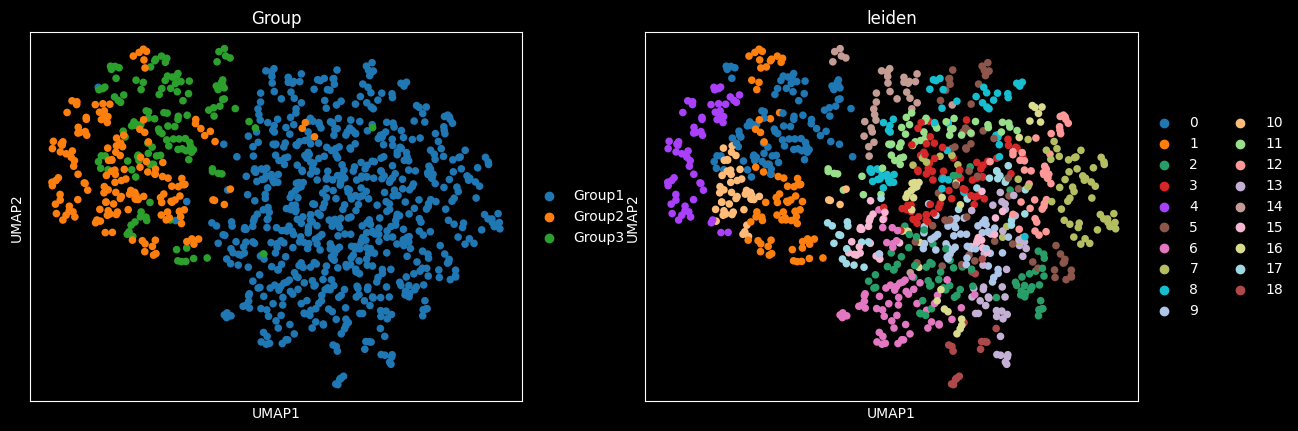

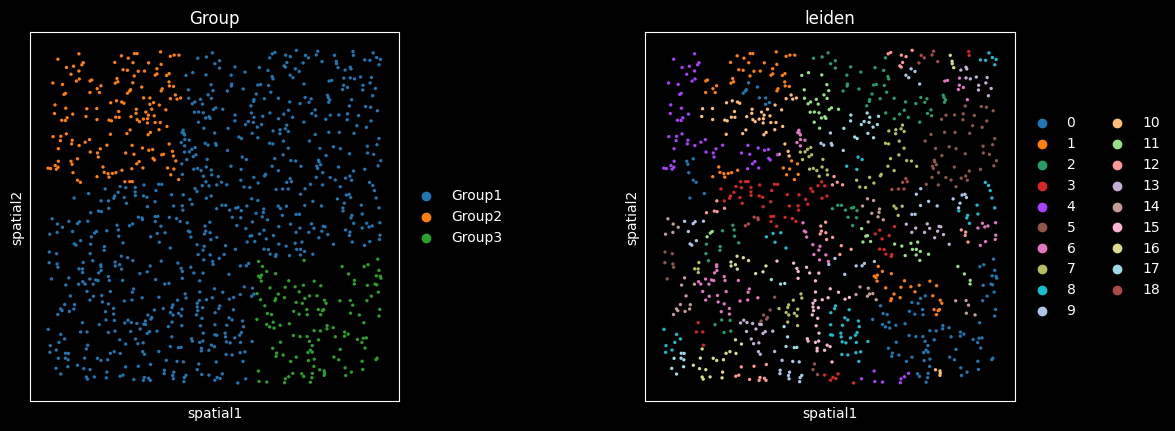

In [19]:
sc.pp.neighbors(new_adata, use_rep='emb', n_neighbors=20)
sc.tl.leiden(new_adata)
sc.tl.umap(new_adata)
sc.pl.umap(new_adata, color=['Group', 'leiden'])
sc.pl.spatial(new_adata, color=['Group', 'leiden'], spot_size=0.01)

In [3]:
import STAGATE_pyG as STAGATE

------Calculating spatial graph...
The graph contains 141904 edges, 9845 cells.
14.4138 neighbors per cell on average.


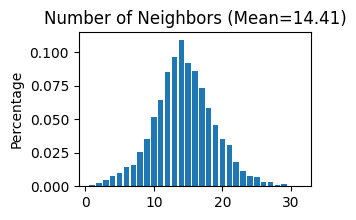

In [15]:
STAGATE.Cal_Spatial_Net(sim1a_adata, rad_cutoff=30)
STAGATE.Stats_Spatial_Net(sim1a_adata)

In [16]:
import scipy.sparse as sp
sim1a_adata.X=sp.csr_matrix(sim1a_adata.X)


In [17]:
adata = STAGATE.train_STAGATE(sim1a_adata)

Size of Input:  (9845, 500)


100%|██████████| 1000/1000 [00:42<00:00, 23.72it/s]


In [18]:
sc.pp.neighbors(adata, use_rep='STAGATE', n_neighbors=20)
sc.tl.leiden(adata)
sc.tl.umap(adata)

In [19]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata
adata = mclust_R(adata, 8, modelNames='EEE', used_obsm='STAGATE')

fitting ...
  |======================================================================| 100%


/home/DingchengYi/miniforge3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/DingchengYi/miniforge3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


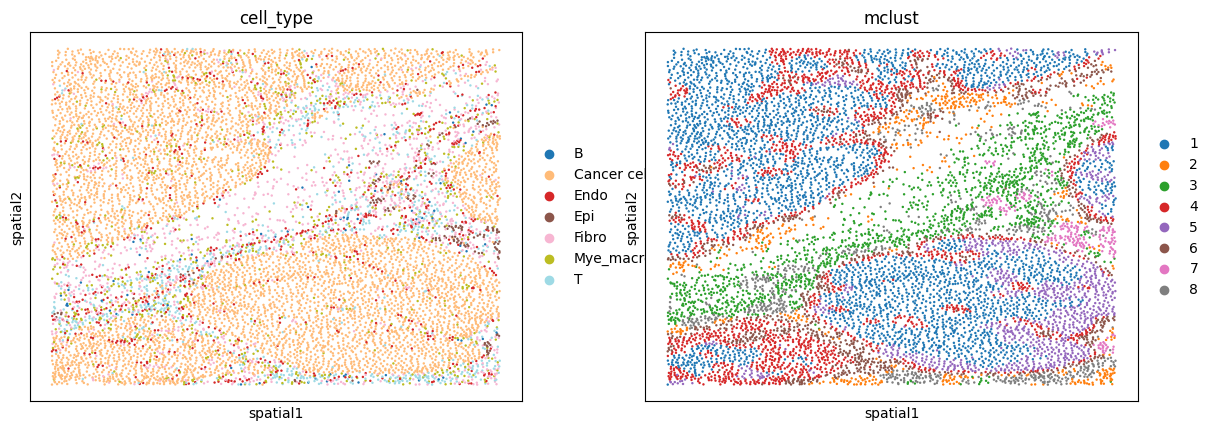

In [20]:
plt.style.use('default')
# sc.pl.umap(adata, color=['sub_cell_type', 'leiden'])
sc.pl.embedding(adata, basis='spatial', color=['cell_type', 'mclust'], save='MERFISH_STAGATE_mclust_2.pdf')